# Tech Vs Humans

In [2]:
import hashlib
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import pinecone
import tiktoken
from datasets import load_dataset
from dotenv import load_dotenv
from langchain.chains import RetrievalQA
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.chat_models import ChatOpenAI
from langchain.docstore.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Pinecone
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm import tqdm

In [3]:
load_dotenv()

True

In [4]:
articles = load_dataset('alexwoolford/tech_vs_humans', split='train')

Found cached dataset json (/Users/alexwoolford/.cache/huggingface/datasets/alexwoolford___json/alexwoolford--tech_vs_humans-a8c3e9b31ba11587/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


In [5]:
articles

Dataset({
    features: ['title', 'author', 'content', 'url'],
    num_rows: 150
})

In [6]:
tokenizer = tiktoken.get_encoding('cl100k_base')

In [7]:
def toktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [8]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,
    length_function=toktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

Each chunk needs an id so we can associate it with the source url. We'll use the first 12 characters of the md5 hash of the url. We use a hash because it's more compact than the url itself, and when a single article is split into multiple chunks, we want to be able to associate each chunk with the original url. We add a suffix to the hash of the url to indicate the chunk number.

In [9]:
def get_url_id(url):
    m = hashlib.md5()
    m.update(url.encode('utf-8'))
    return m.hexdigest()[:12]

In [10]:
embeddings_model = OpenAIEmbeddings(model="text-embedding-ada-002")

Iterate through each article, split it into chunks, and create a document for each chunk. The document metadata includes the chunk embedding, the source url, and the chunk text.

In [11]:
docs = []
for article in tqdm(articles):
    url = article['url']
    content = article['content']
    text_chunks = text_splitter.split_text(content)
    for i, text_chunk in enumerate(text_chunks):
        id = f'{get_url_id(url)}-{i}'
        chunk_embedding = embeddings_model.embed_documents([text_chunk])[0]
        metadata = {
            'id': id,
            'source': url,
            'embedding': chunk_embedding,
            'text': text_chunk,
        }
        doc = Document(page_content=text_chunk, metadata=metadata)
        docs.append(doc)

100%|██████████| 150/150 [01:53<00:00,  1.33it/s]


In [12]:
id_embedding_metadata = []
for doc in docs:
    doc_id = doc.metadata['id']
    embedding = doc.metadata['embedding']
    additional_metadata = {
        'source': doc.metadata.get('source'),
        'text': doc.metadata.get('text')
    }
    id_embedding_metadata.append((doc_id, embedding, additional_metadata))

In [13]:
id_embedding = []
for doc in docs:
    id = doc.metadata['id']
    embedding = doc.metadata['embedding']
    id_embedding.append((id, embedding))

In [14]:
id_embedding_df = pd.DataFrame(id_embedding, columns=['id', 'embedding'])

In [15]:
embedding_df = pd.DataFrame(id_embedding_df['embedding'].to_list())

In [16]:
id_embedding_df = pd.concat([id_embedding_df['id'], embedding_df], axis=1)

In [17]:
# Separate out the embedding values (all columns except the first one) for clustering
X = id_embedding_df.iloc[:, 1:]

In [18]:
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X)

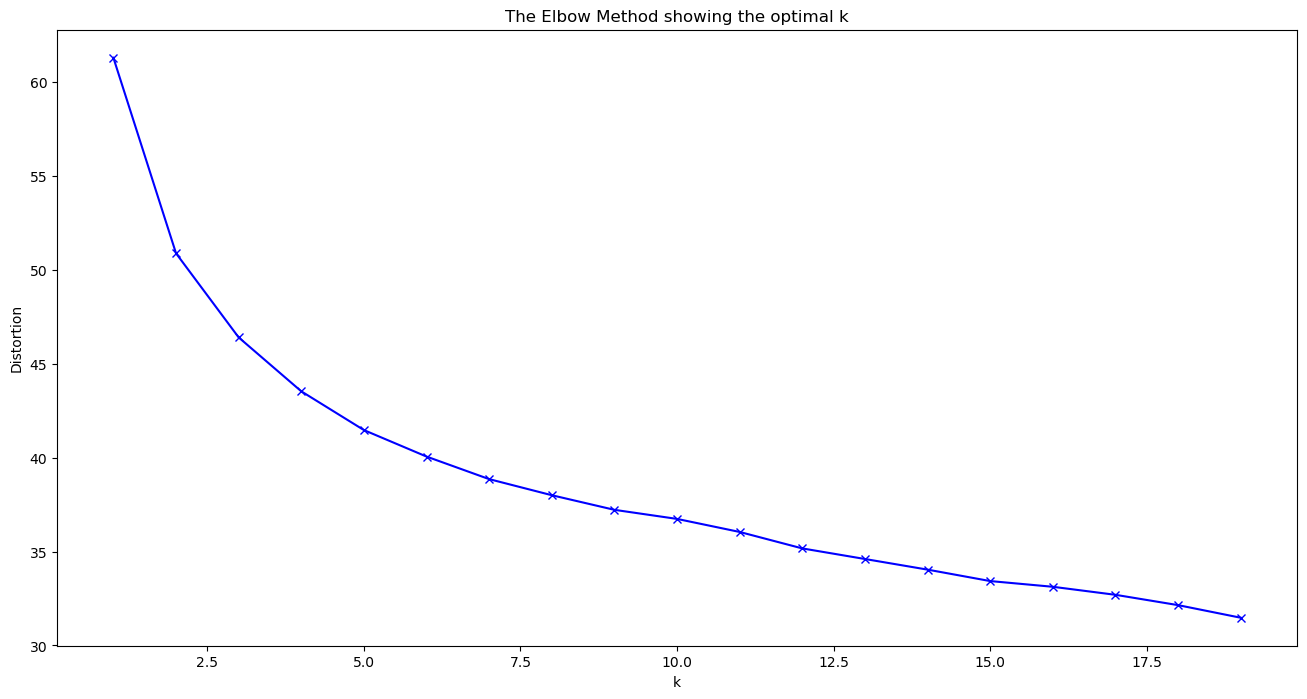

In [19]:
distortions = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10)
    kmeanModel.fit(X_pca)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

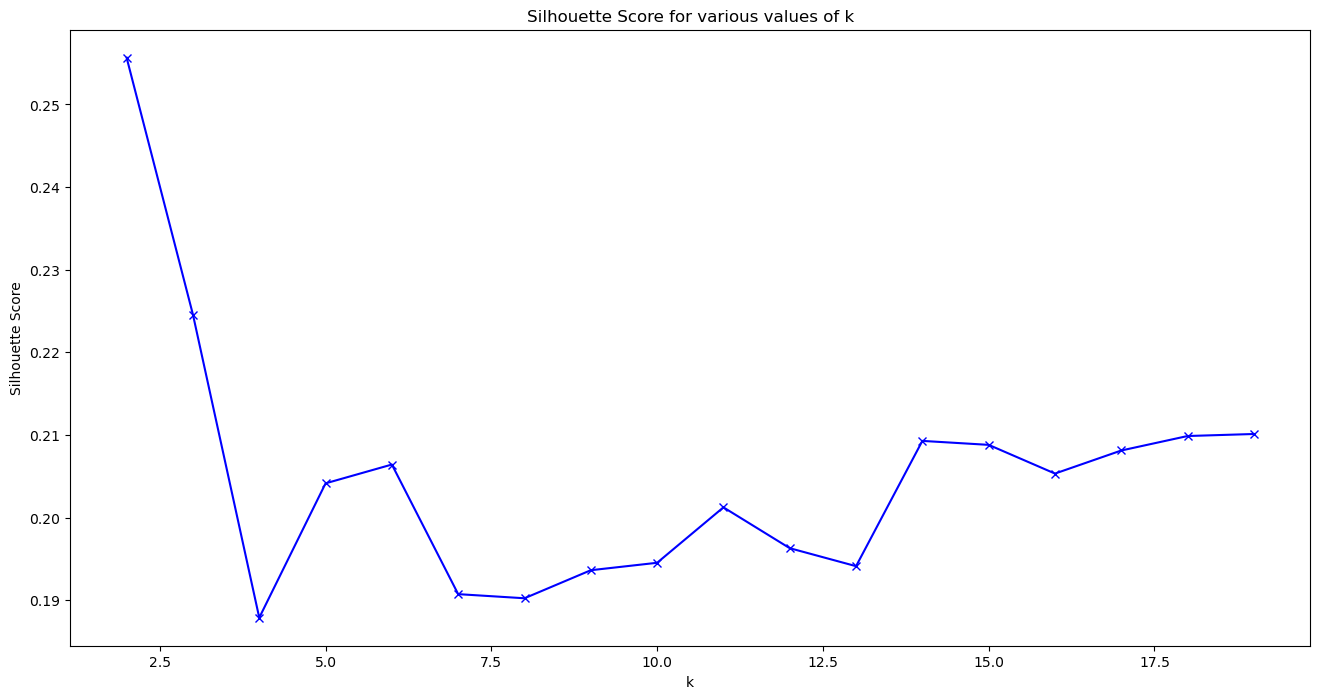

In [20]:
sil = []
K = range(2, 20)  # Starts from 2 because silhouette score is undefined for a single cluster
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10).fit(X_pca)
    labels = kmeans.labels_
    sil.append(silhouette_score(X_pca, labels, metric = 'euclidean'))

plt.figure(figsize=(16,8))
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for various values of k')
plt.show()

In [21]:
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10)
id_embedding_df['cluster_id'] = kmeans.fit_predict(X_pca)

In [22]:
id_cluster_id = id_embedding_df[['id', 'cluster_id']]

In [23]:
id_cluster_dict = dict(zip(id_cluster_id['id'], id_cluster_id['cluster_id']))

In [24]:
# Loop over all the docs and assign the cluster_id to each doc using the id_cluster_dict
for doc in docs:
    doc_id = doc.metadata['id']
    doc.metadata['cluster_id'] = id_cluster_dict.get(doc_id)

In [ ]:
## TODO: cluster articles based on embeddings into themes

In [25]:
index_name = 'articles'
pinecone.init()

if index_name not in pinecone.list_indexes():
    # we create a new index
    pinecone.create_index(
        name=index_name,
        metric='cosine',
        dimension=1536
    )

In [26]:
def chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [27]:
index = pinecone.Index(index_name)

In [28]:
with pinecone.Index(index_name, pool_threads=30) as index:
    # Send requests in parallel
    async_results = [
        index.upsert(vectors=ids_vectors_chunk, async_req=True)
        for ids_vectors_chunk in chunks(id_embedding_metadata, batch_size=100)
    ]
    # Wait for and retrieve responses (this raises in case of error)
    [async_result.get() for async_result in async_results]

In [29]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 402}},
 'total_vector_count': 402}

In [30]:
text_field = "text"

vectorstore = Pinecone(
    index, embeddings_model.embed_query, text_field
)

/Users/alexwoolford/anaconda3/envs/tech_vs_humans/lib/python3.11/site-packages/langchain/vectorstores/pinecone.py:60: UserWarning: Passing in `embedding` as a Callable is deprecated. Please pass in an Embeddings object instead.
  warnings.warn(


In [31]:
# chat completion llm
llm = ChatOpenAI(model_name='gpt-4', temperature=0.0)

In [32]:
# conversational memory
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

In [33]:
# retrieval qa chain
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

In [34]:
query = ("What is the star thrower parable?")

In [35]:
print(qa.run(query))

The Star Thrower Parable, also known as the Starfish Parable, is a story about an old man who used to go to the ocean to do his writing. One morning, after a big storm, he found the beach littered with starfish. He noticed a small boy who was picking up the starfish one by one and throwing them back into the sea. When the old man asked the boy what he was doing, the boy explained that he was saving the starfish from dying under the hot sun. The old man pointed out that there were thousands of starfish and the boy's efforts wouldn't make much of a difference. The boy picked up another starfish, threw it into the sea, and said, "It made a difference to that one!" The parable is often used to illustrate the idea that individual actions can make a difference, even in the face of overwhelming odds.


In [36]:
query = ("Are there are broad themes or patterns? What can we learn about the type of person the author is from the articles?")

In [37]:
print(qa.run(query))

The author seems to be someone who values the process of learning and growth over the end result. They believe in the importance of understanding and appreciating the journey, rather than just focusing on the outcome. They also seem to be patient and understanding, especially when dealing with different types of people during software implementation. The author appears to be knowledgeable about project management and conflict resolution, and they often reference books and other resources to support their points. They also seem to have a passion for music, as they include "Supporting Music" in their posts.
